# Capstone Project - The Battle of the Neighborhoods (Week 2)<a id='top'></a>
### Applied Data Science Capstone by IBM/Coursera

## Table of contents
1. [Introduction: Description & Disscusion of the Business Problem](#introduction)
    1. [Problem Background](#prback)
    2. [Problem Description and Target Audience](#desc_target)
    3. [Success Criteria](#success)
    
2. [Importing Libraries](#libraries)
3. [Collecting Data](#data)
    1. [Barcelona Location](#barloc)
    2. [Getting Venues of Barcelona](#getven)
4. [Exploratary Data Analysis & Data Cleaning](#analysis)
    1. [Explore Neighborhoods in Barcelona](#expbar)
    2. [Filtering Bars from Categories](#filterbars)
    3. [Cleaning data](#cleaning)
    4. [Analyzing Each Neighborhood](#aen)
    5. [Clustering Neighborhoods](#clustering)
    6. [Examining Clusters](#examine)
5. [Results and Discussion](#results)
6. [Conclusion](#conclusion)

## 1. Introduction: Description & Disscusion of the Business Problem <a name="introduction"></a>

### A. Problem Background: <a id="prback"></a>

Barcelona is a city on the coast of northeastern Spain. It is the capital and largest city of the autonomous community of Catalonia, as well as the second most populous municipality of Spain. With a population of 1.6 million within city limits, its urban area extends to numerous neighbouring municipalities within the Province of Barcelona and is home to around 4.8 million people, making it the fifth most populous urban area in the European Union after Paris, the Ruhr area, Madrid, and Milan. And it is also one of the largest metropolises on the Mediterranean Sea.__[1](https://en.wikipedia.org/wiki/Barcelona)__

Barcelona is one of the world's leading tourist, economic, trade fair and cultural centres, and its influence in commerce, education, entertainment, sports, media, fashion, science, and the arts all contribute to its status as one of the major global cities.

This also means that the market is highly competitive. As it is highly developed city so cost of doing business is also one of the highest. Thus, any new business venture or expansion needs to be analysed carefully. The insights derived from analysis will give good understanding of the business environment which help in strategically targeting the market. This will help in reduction of risk. And the return on Investment will be reasonable.

### B. Problem Description and Target Audience: <a id="desc_target"></a>

In this project I will try to find an optimal location for a cocktail bar. Specifically, this report will be **targeted to stakeholders** interested in opening an **Wine Bar** in **Barcelona**, Spain.

Since there are lots of Wine Bars in Barcelona I will try to detect **locations that are not already crowded with Wine bars**. I am also particularly interested in **areas with no Wine bars in vicinity**. I would also prefer locations **as close to city center as possible**, assuming that first two conditions are met.

I will use my data science skills to generate a few most promising neighborhoods based on above criteria. Advantages of each area will then be clearly expressed, so that best possible final location can be chosen by stakeholders.

### C. Success Criteria:¶ <a id="success"></a>

The objective is to locate and recommend to the management which neighborhood of Barcelona city will be best choice to start a Wine Bar. 

This would interest anyone who wants to start a new Wine Bar in Barcelona city.

The success criteria of the project will be a good recommendation of borough/Neighborhood choice to stakeholders based on Lack of such bars in that location.

## 2. Importing Libraries <a name="libraries"></a>

In [80]:
import requests # library to handle requests
import pandas as pd # library for data analsysis
import numpy as np # library to handle data in a vectorized manner
import random # library for random number generation
import json # library to handle JSON files
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # module to convert an address into latitude and longitude values

# libraries for displaying images
from IPython.display import Image 
from IPython.core.display import HTML 
    
# tranforming json file into a pandas dataframe library
from pandas import json_normalize 

#!conda install -c conda-forge folium=0.5.0 --yes
import folium # plotting library
#print (folium.__file__)

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

# import k-means from clustering stage
from sklearn.cluster import KMeans

print('Libraries imported.')
print (folium.__version__)

Libraries imported.
0.11.0


## Entering Account Credentials

In [3]:
# After running this cell I have deleted my account credentials before sharing.
print('Your credentials have been succesfully saved')

Your credentials have been succesfully saved


## 3. Collecting Data <a name="data"></a>

Based on definition of the problem, factors that will influence my decission are:
* number of existing bars in the neighborhood (any type of bar)
* number of and distance to bars in the neighborhood, if any
* distance of neighborhood from city center

I will use barselona geojson data to define the neighborhoods.

Following data sources will be needed to extract/generate the required information:
* coordinate of Barcelona city center will be obtained using **Foursquare API** of well known Barcelona location (**La Rabmla**)

* neighborhood areas will be generated with folium using geojson data of Barcelona districts. 

* number of bars and their type and location in every neighborhood will be obtained using **Foursquare API**

### A. Barcelona Location: <a id='barloc'></a> 

Let's first find the latitude & longitude of Barcelona city center, using specific, well known address "La Rambla" using Four Square API.

In [4]:
address = 'La Rambla, Barcelona'

geolocator = Nominatim(user_agent="foursquare_agent")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('Coordinate of {}: Lat: {}, Lon: {}'.format(address, latitude, longitude))

Coordinate of La Rambla, Barcelona: Lat: 41.3810308, Lon: 2.1732403


Now, Let's create a map centered around La Rambla, Barcelona and play with the zoom level to see how it affects the rendered map.

In [81]:
# create a plain Barcelona map
barcelona_map = folium.Map(location=[latitude, longitude], zoom_start=12)
barcelona_map


folium maps do not render in GitHub so I have added this cell to show the produced map as png.
<img src='map1.png'/>

It seems the coordinates are correct and the map is rendered without any problem.

Now let's load the geojson data to be able to see the neighboorhoods of Barcelona. You can found the geojson file that shows districst of Barcelona and more, __[here](https://github.com/martgnz/bcn-geodata/blob/master/districtes/districtes.json)__. Thanks to **martgnz** for providing this repository. 

In [7]:
barcelona_geo =r'barcelona_urbans.geojson'

folium.GeoJson(barcelona_geo).add_to(barcelona_map)

barcelona_map

folium maps do not render in GitHub so I have added this cell to show the produced map as png.
<img src='map2.png'/>

### B. Getting Venues of Barcelona <a id='getven'></a>

In [39]:
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=SOQLXDVO0LSQDEZLE3WUTP3VLOLNDHPMOTHSUZKLOUA4ETRH&client_secret=FMQXD33ZLTJKYYTS1YXZ00IM3P1I04J5MFSCNNFZT4ZBOKPG&v=20180604&ll=41.3810308,2.1732403&radius=500&limit=100'

Now I will make a get request to get the venues from Barcelona

In [40]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecde8f80be7b4001bfded46'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'El Raval',
  'headerFullLocation': 'El Raval, Barcelona',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 189,
  'suggestedBounds': {'ne': {'lat': 41.3855308045, 'lng': 2.179226469608389},
   'sw': {'lat': 41.376530795499995, 'lng': 2.1672541303916106}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4adcda57f964a5209a4321e3',
       'name': 'Liceu Opera Barcelona (Gran Teatro del Liceo)',
       'location': {'address': 'La Rambla, 51-59',
        'lat': 41.380713238498885,
        'lng': 2.1736061650627523,
        'labeledLatLngs': [{'label': 'display

From the Foursquare API, I know that all of the information is in the items key. So I will declare a function to extract the category of venues.

In [41]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [42]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                categories  \
0  Liceu Opera Barcelona (Gran Teatro del Liceo)               Opera House   
1                       Plaça Reial (Plaza Real)                     Plaza   
2             Mercat de Sant Josep - La Boqueria                    Market   
3                                     Kӕlderkold                  Beer Bar   
4                                   Bar Clemen-s  Mediterranean Restaurant   

         lat       lng  
0  41.380713  2.173606  
1  41.380109  2.175282  
2  41.381959  2.172011  
3  41.381723  2.173348  
4  41.381397  2.171581

In [43]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


In [44]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [210]:
# create map of Barcelona using latitude and longitude values
#map_barcelona = folium.Map(location=[latitude, longitude], zoom_start=10)
folium.GeoJson(barcelona_geo).add_to(barcelona_map)
# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(barcelona_map)  
    

barcelona_map
# folium maps do not render in GitHub so I have added this cell to shop the produced map as html.
import webbrowser
barcelona_map.save('map3.html')
webbrowser.open('map3.html')
#from IPython.display import IFrame
#IFrame(src='map2.html', width=980, height=600)

True

folium maps do not render in GitHub so I have added this cell to show the produced map as png.
<img src='map3.png'/>

## 4. Exploratary Data Analysis & Data Cleaning <a name="analysis"></a>

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the **number of restaurants in every area candidate**:

Let's explore the first neighborhood in our dataframe.

Get the neighborhood's name.

In [46]:
neighborhoods.loc[0, 'Neighborhood']

'Carme'

Get the neighborhood's latitude and longitude values.

In [47]:
neighborhood_latitude = neighborhoods.loc[0, 'Latitude'] # neighborhood latitude value
neighborhood_longitude = neighborhoods.loc[0, 'Longitude'] # neighborhood longitude value

neighborhood_name = neighborhoods.loc[0, 'Neighborhood'] # neighborhood name

print('Latitude and longitude values of {} are {}, {}.'.format(neighborhood_name, 
                                                               neighborhood_latitude, 
                                                               neighborhood_longitude))

Latitude and longitude values of Carme are 41.379796999999996, 2.166283.


#### Now, let's get the top 100 venues that are in Carme within a radius of 500 meters.

First, let's create the GET request URL. Name your URL url.

In [48]:
# type your answer here
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=SOQLXDVO0LSQDEZLE3WUTP3VLOLNDHPMOTHSUZKLOUA4ETRH&client_secret=FMQXD33ZLTJKYYTS1YXZ00IM3P1I04J5MFSCNNFZT4ZBOKPG&v=20180604&ll=41.379796999999996,2.166283&radius=500&limit=100'

In [49]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5ecde97b9fcb92001b1b9408'},
 'response': {'suggestedFilters': {'header': 'Tap to show:',
   'filters': [{'name': 'Open now', 'key': 'openNow'}]},
  'headerLocation': 'El Raval',
  'headerFullLocation': 'El Raval, Barcelona',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 171,
  'suggestedBounds': {'ne': {'lat': 41.3842970045, 'lng': 2.1722690560423503},
   'sw': {'lat': 41.375296995499994, 'lng': 2.1602969439576496}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4b4d9934f964a5209bd426e3',
       'name': 'Las Fernández',
       'location': {'address': 'Carrer de les Carretes 11',
        'lat': 41.37818332916318,
        'lng': 2.166353561390829,
        'labeledLatLngs': [{'label': 'display',
          'lat': 41.3

In [50]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [51]:
# Now we are ready to clean the json and structure it into a pandas dataframe.
venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

name                categories        lat       lng
0   Las Fernández  Mediterranean Restaurant  41.378183  2.166354
1  Bodega Armando                  Wine Bar  41.379974  2.164891
2        Chulapio              Cocktail Bar  41.379264  2.165905
3    Pesca Salada              Cocktail Bar  41.378430  2.165523
4           Arume        Spanish Restaurant  41.378953  2.166008

In [52]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

100 venues were returned by Foursquare.


### A. Explore Neighborhoods in Barcelona <a id='expbar'></a>

Let's create a function to repeat the same process to all the neighborhoods in Barcelona

In [53]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [54]:
# type your answer here

barcelona_venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

Carme
Sant Pau
Sant Pau
Sant Pau
Sant Pau
Sant Pau
Sant Pau
Sant Pau
Sant Pau
Avinyó
Tibidabo
Tibidabo
Tibidabo
Pamplona
Almogàvers
Pamplona
Almogàvers
Taquígraf Garriga
Rocafort
Aragó
Aragó
Aragó
Aragó
Salvador Seguí
Muntaner
Muntaner
Amigó
Amigó
Arc del Teatre
Arc del Teatre
Aribau
Aribau
Aribau
Aribau
Aribau
Aribau
Rocafort
Rocafort
Aribau
Aribau
Aribau
Aribau
Aribau
Aribau
Aribau
Aribau
Aribau
Avinyó
Avinyó
Balmes
Balmes
Born
Born
Sitges
Casanova
Casanova
Consell de Cent
Consell de Cent
Consell de Cent
Còrsega
Còrsega
Còrsega
Dos de Maig
Dos de Maig
Reial
Reial
Reial
Reial
Diagonal
Roger de Llúria
Lepant
Loreto
Sant Antoni
Marià Cubí
Marià Cubí
Gran de Gràcia
Gran de Gràcia
Gran de Gràcia
Muntaner
Muntaner
Muntaner
Narcís Oller
Nou de Sant Francesc
París
París
Virreina
Pinar del Río
Pinar del Río
Pinar del Río
Pinar del Río
Francesc Tàrrega
Francesc Tàrrega
Francesc Tàrrega
Francesc Tàrrega
Provença
Provença
Provença
Providència
Regent Mendieta
Sabino Arana
Sant Eusebi
Sant Eusebi


In [55]:
print(barcelona_venues.shape)
barcelona_venues.head()

(44130, 7)


Neighborhood  Neighborhood Latitude  Neighborhood Longitude           Venue  \
0        Carme              41.379797                2.166283   Las Fernández   
1        Carme              41.379797                2.166283  Bodega Armando   
2        Carme              41.379797                2.166283        Chulapio   
3        Carme              41.379797                2.166283    Pesca Salada   
4        Carme              41.379797                2.166283           Arume   

   Venue Latitude  Venue Longitude            Venue Category  
0       41.378183         2.166354  Mediterranean Restaurant  
1       41.379974         2.164891                  Wine Bar  
2       41.379264         2.165905              Cocktail Bar  
3       41.378430         2.165523              Cocktail Bar  
4       41.378953         2.166008        Spanish Restaurant

### B. Filtering Bars from Categories <a id='filterbars'></a>

In [91]:
bars = barcelona_venues[barcelona_venues['Venue Category'].str.contains('Bar', regex=False)]
bars = bars.reset_index(drop=True)
bars.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude           Venue  \
0        Carme              41.379797                2.166283  Bodega Armando   
1        Carme              41.379797                2.166283        Chulapio   
2        Carme              41.379797                2.166283    Pesca Salada   
3        Carme              41.379797                2.166283           33/45   
4        Carme              41.379797                2.166283        Foxy Bar   

   Venue Latitude  Venue Longitude Venue Category  
0       41.379974         2.164891       Wine Bar  
1       41.379264         2.165905   Cocktail Bar  
2       41.378430         2.165523   Cocktail Bar  
3       41.381059         2.167399   Cocktail Bar  
4       41.380388         2.164357            Bar

Let's check how many Bars were returned for each neighborhood

In [92]:
bars.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count()

Neighborhood                 Venue Category    
Abaixadors                   Bar                     6
                             Cocktail Bar            5
                             Wine Bar                3
Alba                         Bar                    15
                             Beer Bar                3
                             Cocktail Bar           21
                             Salon / Barbershop      3
                             Wine Bar                6
Aldana                       Bar                     6
                             Beer Bar                2
                             Cocktail Bar            7
                             Gay Bar                 1
                             Wine Bar                1
Allada-Vermell               Bar                     2
                             Cocktail Bar            6
                             Wine Bar                5
Almogàvers                   Bar                     6
                 

#### Let's find out how many unique categories can be curated from all the returned venues

In [131]:
bars['Venue Category'].unique()

array(['Wine Bar', 'Cocktail Bar', 'Bar', 'Beer Bar', 'Gay Bar',
       'Salon / Barbershop', 'Hotel Bar', 'Sports Bar', 'Juice Bar',
       'Karaoke Bar', 'Hookah Bar', 'Beach Bar'], dtype=object)

### C. Cleaning data <a name='cleaning' ></a>

In [147]:
bars = bars[bars['Venue Category'] != 'Salon / Barbershop']
bars['Venue Category'].unique()

array(['Wine Bar', 'Cocktail Bar', 'Bar', 'Beer Bar', 'Gay Bar',
       'Hotel Bar', 'Sports Bar', 'Juice Bar', 'Karaoke Bar',
       'Hookah Bar', 'Beach Bar'], dtype=object)

In [148]:
print('There are {} unique categories.'.format(bars['Venue Category'].nunique()))

There are 11 unique categories.


In [149]:
bars_list = bars['Venue Category'].unique().tolist()
bars_dict = {}
for idx, bar in enumerate(bars_list):
    bars_dict[bar] = idx
bars_dict

{'Wine Bar': 0,
 'Cocktail Bar': 1,
 'Bar': 2,
 'Beer Bar': 3,
 'Gay Bar': 4,
 'Hotel Bar': 5,
 'Sports Bar': 6,
 'Juice Bar': 7,
 'Karaoke Bar': 8,
 'Hookah Bar': 9,
 'Beach Bar': 10}

So we are interested in category 1 for Cocktail Bar.

### D. Analyzing Each Neighborhood <a id='aen'></a>

In [150]:
# one hot encoding
barcelona_onehot = pd.get_dummies(bars[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
barcelona_onehot['Neighborhood'] = bars['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [barcelona_onehot.columns[-1]] + list(barcelona_onehot.columns[:-1])
barcelona_onehot = barcelona_onehot[fixed_columns]

barcelona_onehot.head()

Neighborhood  Bar  Beach Bar  Beer Bar  Cocktail Bar  Gay Bar  Hookah Bar  \
0        Carme    0          0         0             0        0           0   
1        Carme    0          0         0             1        0           0   
2        Carme    0          0         0             1        0           0   
3        Carme    0          0         0             1        0           0   
4        Carme    1          0         0             0        0           0   

   Hotel Bar  Juice Bar  Karaoke Bar  Sports Bar  Wine Bar  
0          0          0            0           0         1  
1          0          0            0           0         0  
2          0          0            0           0         0  
3          0          0            0           0         0  
4          0          0            0           0         0

In [151]:
barcelona_onehot.shape

(4064, 12)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [152]:
barcelona_grouped = barcelona_onehot.groupby('Neighborhood').mean().reset_index()
barcelona_grouped

Neighborhood       Bar  Beach Bar  Beer Bar  Cocktail Bar  \
0                     Abaixadors  0.428571   0.000000  0.000000      0.357143   
1                           Alba  0.333333   0.000000  0.066667      0.466667   
2                         Aldana  0.352941   0.000000  0.117647      0.411765   
3                 Allada-Vermell  0.153846   0.000000  0.000000      0.461538   
4                     Almogàvers  0.857143   0.000000  0.000000      0.000000   
5                          Amigó  0.000000   0.000000  0.000000      1.000000   
6             Antic de Sant Joan  0.125000   0.000000  0.125000      0.375000   
7                          Aragó  0.000000   0.000000  0.200000      0.500000   
8                 Arc del Teatre  0.538462   0.000000  0.153846      0.153846   
9                         Aribau  0.000000   0.000000  0.143678      0.672414   
10                       Aviació  0.200000   0.000000  0.200000      0.600000   
11                        Avinyó  0.315789   0.000000  0.000000      0.236842   
12                        Balmes  0.000000   0.000000  0.152542      0.627119   
13           Basses de Sant Pere  1.000000   0.000000  0.000000      0.000000   
14                       Bergara  0.250000   0.000000  0.000000      0.375000   
15                         Blesa  0.333333   0.000000  0.083333      0.416667   
16                          Born  0.141667   0.000000  0.100000      0.458333   
17                       Botella  0.400000   0.000000  0.100000      0.450000   
18                          Bruc  0.000000   0.000000  0.333333      0.333333   
19                     Bruniquer  0.800000   0.000000  0.000000      0.200000   
20                  Buenos Aires  0.285714   0.000000  0.000000      0.571429   
21                          Camp  0.785714   0.000000  0.000000      0.071429   
22                       Carassa  0.461538   0.000000  0.000000      0.307692   
23                       Carders  0.125000   0.000000  0.000000      0.500000   
24                         Carme  0.340000   0.000000  0.080000      0.420000   
25                      Casanova  0.100000   0.000000  0.150000      0.600000   
26                          Casp  0.375000   0.000000  0.250000      0.375000   
27                     Catalunya  0.000000   0.000000  0.076923      0.615385   
28                     Comercial  0.142857   0.000000  0.142857      0.428571   
29                        Comerç  0.250000   0.000000  0.000000      0.500000   
30                 Comte Borrell  1.000000   0.000000  0.000000      0.000000   
31                Comte d'Urgell  0.333333   0.000000  0.000000      0.333333   
32         Comtessa de Sobradiel  0.333333   0.000000  0.000000      0.250000   
33                     Concepció  0.000000   0.000000  0.000000      0.750000   
34               Consell de Cent  0.055556   0.000000  0.166667      0.472222   
35               Corts Catalanes  0.148148   0.000000  0.148148      0.435185   
36                    Costa Rica  1.000000   0.000000  0.000000      0.000000   
37              Creu dels Molers  0.285714   0.000000  0.214286      0.285714   
38                        Còdols  0.400000   0.000000  0.000000      0.200000   
39                       Còrsega  0.413793   0.000000  0.000000      0.448276   
40                    Deu i Mata  0.200000   0.000000  0.200000      0.600000   
41                      Diagonal  0.320755   0.000000  0.094340      0.509434   
42                     Diputació  0.142857   0.000000  0.142857      0.428571   
43                 Doctor Andreu  0.500000   0.000000  0.000000      0.500000   
44                Doctor Marañón  0.666667   0.000000  0.000000      0.000000   
45                 Doctor Trueta  0.400000   0.000000  0.100000      0.300000   
46                       Domingo  0.000000   0.000000  0.333333      0.500000   
47                   Dos de Maig  0.750000   0.000000  0.250000      0.000000   
48                       Eivissa  0.500000   0.0000

In [153]:
barcelona_grouped.shape

(191, 12)

#### Let's print each neighborhood along with the top 5 most common venues

In [154]:
num_top_venues = 5

for hood in barcelona_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = barcelona_grouped[barcelona_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abaixadors----
          venue  freq
0           Bar  0.43
1  Cocktail Bar  0.36
2      Wine Bar  0.21
3     Beach Bar  0.00
4      Beer Bar  0.00


----Alba----
          venue  freq
0  Cocktail Bar  0.47
1           Bar  0.33
2      Wine Bar  0.13
3      Beer Bar  0.07
4     Beach Bar  0.00


----Aldana----
          venue  freq
0  Cocktail Bar  0.41
1           Bar  0.35
2      Beer Bar  0.12
3       Gay Bar  0.06
4      Wine Bar  0.06


----Allada-Vermell----
          venue  freq
0  Cocktail Bar  0.46
1      Wine Bar  0.38
2           Bar  0.15
3     Beach Bar  0.00
4      Beer Bar  0.00


----Almogàvers----
          venue  freq
0           Bar  0.86
1     Juice Bar  0.14
2     Beach Bar  0.00
3      Beer Bar  0.00
4  Cocktail Bar  0.00


----Amigó----
          venue  freq
0  Cocktail Bar   1.0
1           Bar   0.0
2     Beach Bar   0.0
3      Beer Bar   0.0
4       Gay Bar   0.0


----Antic de Sant Joan----
          venue  freq
0  Cocktail Bar  0.38
1      Wine Bar  0.38


----Grassot----
          venue  freq
0  Cocktail Bar   1.0
1           Bar   0.0
2     Beach Bar   0.0
3      Beer Bar   0.0
4       Gay Bar   0.0


----Grau i Torras----
          venue  freq
0           Bar   0.6
1      Beer Bar   0.2
2     Juice Bar   0.2
3     Beach Bar   0.0
4  Cocktail Bar   0.0


----Gràcia----
          venue  freq
0  Cocktail Bar  0.46
1           Bar  0.17
2      Beer Bar  0.17
3      Wine Bar  0.17
4    Sports Bar  0.03


----Guilleries----
          venue  freq
0           Bar  0.45
1  Cocktail Bar  0.36
2      Wine Bar  0.18
3     Beach Bar  0.00
4      Beer Bar  0.00


----Gutenberg----
          venue  freq
0           Bar  0.50
1  Cocktail Bar  0.25
2      Wine Bar  0.25
3     Beach Bar  0.00
4      Beer Bar  0.00


----Guàrdia----
          venue  freq
0           Bar  0.39
1      Beer Bar  0.26
2  Cocktail Bar  0.22
3      Wine Bar  0.13
4     Beach Bar  0.00


----Heures----
          venue  freq
0      Wine Bar  0.50
1           Bar  0.33
2      Be

          venue  freq
0           Bar   1.0
1     Beach Bar   0.0
2      Beer Bar   0.0
3  Cocktail Bar   0.0
4       Gay Bar   0.0


----Reial----
          venue  freq
0           Bar  0.47
1      Wine Bar  0.38
2      Beer Bar  0.16
3     Beach Bar  0.00
4  Cocktail Bar  0.00


----Requesens----
          venue  freq
0  Cocktail Bar  0.44
1           Bar  0.31
2      Beer Bar  0.12
3       Gay Bar  0.06
4      Wine Bar  0.06


----Rere Palau----
          venue  freq
0  Cocktail Bar  0.38
1           Bar  0.31
2      Wine Bar  0.23
3      Beer Bar  0.08
4     Beach Bar  0.00


----Riera de Sant Miquel----
          venue  freq
0  Cocktail Bar   0.6
1           Bar   0.2
2      Wine Bar   0.2
3     Beach Bar   0.0
4      Beer Bar   0.0


----Rius i Taulet----
          venue  freq
0  Cocktail Bar   0.4
1           Bar   0.2
2     Hotel Bar   0.2
3      Beer Bar   0.1
4      Wine Bar   0.1


----Robador----
          venue  freq
0  Cocktail Bar  0.45
1      Beer Bar  0.18
2           

#### Let's put that into a *pandas* dataframe

First, let's write a function to sort the venues in descending order.

In [155]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [177]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = barcelona_grouped['Neighborhood']

for ind in np.arange(barcelona_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(barcelona_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0      Abaixadors                   Bar          Cocktail Bar   
1            Alba          Cocktail Bar                   Bar   
2          Aldana          Cocktail Bar                   Bar   
3  Allada-Vermell          Cocktail Bar              Wine Bar   
4      Almogàvers                   Bar             Juice Bar   

  3rd Most Common Venue 4th Most Common Venue 5th Most Common Venue  \
0              Wine Bar            Sports Bar           Karaoke Bar   
1              Wine Bar              Beer Bar            Sports Bar   
2              Beer Bar              Wine Bar               Gay Bar   
3                   Bar            Sports Bar           Karaoke Bar   
4              Wine Bar            Sports Bar           Karaoke Bar   

  6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0             Juice Bar             Hotel Bar            Hookah Bar   
1           Karaoke Bar             Juice Bar             Hotel Bar   
2            Sports Bar           Karaoke Bar             Juice Bar   
3             Juice Bar             Hotel Bar            Hookah Bar   
4             Hotel Bar            Hookah Bar               Gay Bar   

  9th Most Common Venue 10th Most Common Venue  
0               Gay Bar               Beer Bar  
1            Hookah Bar                Gay Bar  
2             Hotel Bar             Hookah Bar  
3               Gay Bar               Beer Bar  
4          Cocktail Bar               Beer Bar

### E. Clustering Neighborhoods <a id='clustering'></a>

Run *k*-means to cluster the neighborhood into 12 clusters.

In [178]:
# set number of clusters
kclusters = 11

barcelona_grouped_clustering = barcelona_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(barcelona_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([10,  0,  0,  6,  1,  2,  6,  4,  3,  4])

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [179]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_, allow_duplicates=True)

barcelona_merged = bars

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
barcelona_merged = barcelona_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
barcelona_merged['Cluster Labels'] = df['Venue Category'].map(bars_dict)
#barcelona_merged = barcelona_merged.drop(barcelona_merged.columns[7], axis=1)
barcelona_merged.head() # check the last columns!

Neighborhood  Neighborhood Latitude  Neighborhood Longitude           Venue  \
0        Carme              41.379797                2.166283  Bodega Armando   
1        Carme              41.379797                2.166283        Chulapio   
2        Carme              41.379797                2.166283    Pesca Salada   
3        Carme              41.379797                2.166283           33/45   
4        Carme              41.379797                2.166283        Foxy Bar   

   Venue Latitude  Venue Longitude Venue Category  Cluster Labels  \
0       41.379974         2.164891       Wine Bar               0   
1       41.379264         2.165905   Cocktail Bar               1   
2       41.378430         2.165523   Cocktail Bar               1   
3       41.381059         2.167399   Cocktail Bar               1   
4       41.380388         2.164357            Bar               2   

  1st Most Common Venue 2nd Most Common Venue 3rd Most Common Venue  \
0          Cocktail Bar                   Bar              Beer Bar   
1          Cocktail Bar                   Bar              Beer Bar   
2          Cocktail Bar                   Bar              Beer Bar   
3          Cocktail Bar                   Bar              Beer Bar   
4          Cocktail Bar                   Bar              Beer Bar   

  4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0              Wine Bar               Gay Bar             Hotel Bar   
1              Wine Bar               Gay Bar             Hotel Bar   
2              Wine Bar               Gay Bar             Hotel Bar   
3              Wine Bar               Gay Bar             Hotel Bar   
4              Wine Bar               Gay Bar             Hotel Bar   

  7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0            Sports Bar           Karaoke Bar             Juice Bar   
1            Sports Bar           Karaoke Bar             Juice Bar   
2            Sports Bar           Karaoke Bar             Juice Bar   
3            Sports Bar           Karaoke Bar             Juice Bar   
4            Sports Bar           Karaoke Bar             Juice Bar   

  10th Most Common Venue  
0             Hookah Bar  
1             Hookah Bar  
2             Hookah Bar  
3             Hookah Bar  
4             Hookah Bar

Finally, let's visualize the resulting clusters

In [213]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)
folium.GeoJson(barcelona_geo).add_to(map_clusters)
# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster, venue in zip(barcelona_merged['Neighborhood Latitude'],
                                         barcelona_merged['Neighborhood Longitude'],
                                         barcelona_merged['Neighborhood'],
                                         barcelona_merged['Cluster Labels'],
                                         barcelona_merged['Venue Category']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster) + '  ' + venue, parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters
# folium maps do not render in GitHub so I have added this cell to shop the produced map as html.
#import webbrowser
#map_clusters.save('map4.html')
#webbrowser.open('map4.html')
#from IPython.display import IFrame
#IFrame(src='map2.html', width=980, height=600)

folium maps do not render in GitHub so I have added this cell to show the produced map as png.
<img src='map4.png'/>

### F. Examining Clusters <a id='examine'></a>

In [190]:
wine_bars = bars[bars['Venue Category'] == 'Wine Bar']
wine_bars.head()

Neighborhood  Neighborhood Latitude  Neighborhood Longitude  \
0         Carme              41.379797                2.166283   
24     Sant Pau              41.375518                2.167949   
40     Sant Pau              41.375518                2.167949   
56     Sant Pau              41.375518                2.167949   
72     Sant Pau              41.375518                2.167949   

             Venue  Venue Latitude  Venue Longitude Venue Category  
0   Bodega Armando       41.379974         2.164891       Wine Bar  
24       Sasha Bar       41.373887         2.163625       Wine Bar  
40       Sasha Bar       41.373887         2.163625       Wine Bar  
56       Sasha Bar       41.373887         2.163625       Wine Bar  
72       Sasha Bar       41.373887         2.163625       Wine Bar

In [198]:
wbg = wine_bars.groupby(['Neighborhood', 'Venue Category'])['Venue Category'].count().sort_values(ascending=False)
wbg

Neighborhood                 Venue Category
Reial                        Wine Bar          53
Mercè                        Wine Bar          38
Born                         Wine Bar          36
Corts Catalanes              Wine Bar          29
Tuset                        Wine Bar          21
Milans                       Wine Bar          20
Avinyó                       Wine Bar          17
Sol                          Wine Bar          15
Sant Pau                     Wine Bar          14
Escudellers                  Wine Bar          11
Matilde                      Wine Bar          10
Comtessa de Sobradiel        Wine Bar          10
Consell de Cent              Wine Bar          10
Aribau                       Wine Bar          10
Gran de Gràcia               Wine Bar           9
Francisco Giner              Wine Bar           8
Torrent d'en Vidalet         Wine Bar           8
Pau Claris                   Wine Bar           8
Palma de Sant Just           Wine Bar           8
Pere C

In [199]:
type(wbg)

pandas.core.series.Series

In [206]:
#Let's reduce the group disctricts which have wine bars between 10 and 20.
mask = ((wbg <= 20) & (wbg >= 10) )
wbg = wbg[mask]

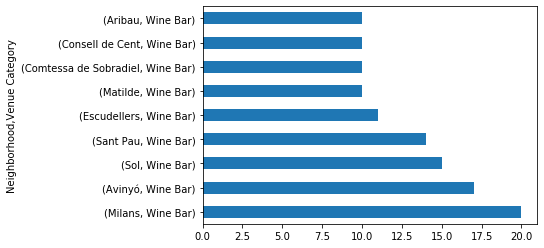

In [208]:
wbg.plot(kind='barh')

These 9 districts can be a good choice for a new Wine Bar to open.

## Results and Discussion <a name="results"></a>

Our analysis shows that although there is a great number of bars in Barcelona, there are pockets of low restaurant density fairly close to city center. Highest concentration of Wine Bars was detected north and west from La Rambla, but our attention was focused on nine districts which offer a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics *and* a number of pockets of low Wine Bar density.

After directing our attention to this more narrow area of interest (covering approx. 5x5km south-east from Alexanderplatz) we first created a dense grid of location candidates (spaced 100m appart); those locations were then filtered so that those with more than two restaurants in radius of 250m and those with an Italian restaurant closer than 400m were removed.

Those location candidates were then clustered to create zones of interest which contain greatest number of location candidates. Addresses of centers of those zones were also generated using reverse geocoding to be used as markers/starting points for more detailed local analysis based on other factors.

Result of all of the zones containing largest number of potential new locations based on number of and distance to existing venues - both bars in general and Wine Bars particularly. This, of course, does not imply that those zones are actually optimal locations for a new Wine Bar! Purpose of this analysis was to only provide info on areas close to Barcelona center but not crowded with existing Wine Bars. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion <a name="conclusion"></a>

Purpose of this project was to identify areas close to center with low number of Wine Bars  in order to aid stakeholders in narrowing down the search for optimal location for a new Wine Bar. By calculating bar density distribution from Foursquare data we have identified the locations which satisfy some basic requirements regarding existing nearby Wine Bars. 

Final decission on optimal location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location (proximity to park or water), levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.

## G. References

1. [Barcelona - Wikipedia](https://en.wikipedia.org/wiki/Barcelona)

[TOP](#top)